# Neural Network Activation Function Comparison Lab

1. Data Preparation: Fashion MNIST + Split
2. Model Implementation: FNN for 5 activation function
3. Training: Use the validation set to tune hyper-parameters and prevent over-fitting
4. Evaluation: accuracy (for classification) and MSE (for regression) + Plot the training and validation loss curve
5. Analysis

In [27]:
# 0. Import Packages
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import numpy as np

## 1. Data Preparation:
1. Data-set: *Fashion MNIST*
2. My answer is divided into 2 parts, data preparation for first 6 models and then for ResNet, becuase *RestNet-18 requires the input size to be $224 \times 224$*
3. To be specific, I seperate data preparation for each model to be 4 parts;
   - Nomalize input (in the case of CV, it's normalize pixel values)
   - Load dataset: Fashion MNIST, both for train and test
   - Split dataset: train and validation
   - Create data loaders for 3 sets
        - train
        - val: tune hyperparameters, early stopping
        - test: evaluate the model's generalization and performance

In [28]:
def prepare_data(dataset, batch_size=64, resize=None, num_workers=0):
    # 1.1 Define transformations
    data_transforms = [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    if resize: # this is for ResNet
        data_transforms.insert(0, transforms.Resize(resize))
    data_transform = transforms.Compose(data_transforms)

    # 1.2 Download the dataset
    dataset = dataset(root='./data', train=True, transform=data_transform, download=True)

    # 1.3 Seperate into training, validation, and testing set
    total_size = len(dataset)
    train_size = int(0.8 * total_size)
    val_size = total_size - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    # 1.4 Create data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    return train_loader, val_loader

# Usage for the first 6 models (FashionMNIST with 28x28 images)
train_loader, val_loader = prepare_data(torchvision.datasets.FashionMNIST)

# Usage for the second part (FashionMNIST with 224x224 images for ResNet)
train_loader2, val_loader2 = prepare_data(torchvision.datasets.FashionMNIST, resize=(224, 224))


## 2. Model Implementation:
1. Design a feedforward neural network with multiple layers.
2. Implement the network five times, each time using one of the activation functions listed above.

### Hints: Pay attention to the training dynamics. Some activation functions might require adjustments in terms of initialization or optimization techniques.

1. Sigmoid
- Initialization: input range from $(0, 1)$, weights around zero
2. TanH
- Initialization: input range from $(-1, 1)$, weights around zero
3. ReLU
- Initialization: He initialization or LeCun initialization (??? what is it)
4. Leaky ReLU

5. Swish

6. LeNet

7. ResNet
- ResNet-18 requires $224 \times 224$ input, with $3$ channels(RGB)
- ResNet-18, as a pre-trained model, have ouput feature $1000 \times 1000$
- In the case that I try to use ResNet-18 as a pre-trained model to classify Fashion MNIST, so some adaptation work should be done here.

In [29]:
# 2.1.1 Design a FNN class
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, activation_func):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.activation_func = activation_func

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.activation_func(self.fc1(x))
        x = self.activation_func(self.fc2(x))
        x = self.fc3(x)
        return x

# 2.1.2 Define parameters for FNN class
input_size = 28 * 28
hidden_size = 128
num_classes = 10

# 2.1. 3 Create instance of FNN with different activation function
sigmoid_net = FeedForwardNN(input_size, hidden_size, num_classes, nn.Sigmoid())
tanh_net = FeedForwardNN(input_size, hidden_size, num_classes, nn.Tanh())
relu_net = FeedForwardNN(input_size, hidden_size, num_classes, nn.ReLU())
leaky_relu_net = FeedForwardNN(input_size, hidden_size, num_classes, nn.LeakyReLU())
swish_net = FeedForwardNN(input_size, hidden_size, num_classes, lambda x: x * torch.sigmoid(x))

In [30]:
# 2.2 Design a LeNet
class LeNet(nn.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [31]:
# 2.3 Design a ResNet using pre-trained ResNet-18 

# 2.3.1 Define a custom classification head
class CustomResNet(nn.Module): 
    def __init__(self, pretrained_resnet):
        super(CustomResNet, self).__init__()
        self.resnet = pretrained_resnet
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False) # modify the 'conv1' layer from 3 channels to 1
        self.classifier = nn.Sequential(
            nn.Linear(1000, 512),  # ResNet-18 has 1000 output features
            nn.ReLU(),
            nn.Linear(512, 10)     # 10 classes for FashionMNIST
        )

    def forward(self, x):
        features = self.resnet(x)
        out = self.classifier(features)
        return out

# 2.3.2 Load pre-trained ResNet-18 model
resnet = models.resnet18(weights='ResNet18_Weights.DEFAULT')

# 2.3.3 Create a custom model
custom_resnet = CustomResNet(resnet)

## 3. Training:
1. Train each of the five neural network models on the training dataset.
2. Use the validation set to tune hyperparameters and prevent overfitting.

In [57]:
# Define the training and evaluation loop
def train_and_evaluate(model, train_loader, val_loader, num_epochs, learning_rate):
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []  # Track training accuracy
    val_accuracies = []    # Track validation accuracy

    best_val_loss = float('inf')  # Initialize with a high value
    best_model_state = None

    for epoch in range(num_epochs):
        # Training loop
        model.train()
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        train_loss = total_loss / len(train_loader)
        train_accuracy = correct_predictions / total_samples
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct_predictions = 0
        total_samples = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct_predictions += (predicted == labels).sum().item()
                total_samples += labels.size(0)

        val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct_predictions / total_samples
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print training and validation results
        print(f'Epoch [{epoch + 1}/{num_epochs}] '
              f'Train Loss: {train_loss:.4f} '
              f'Train Acc: {train_accuracy * 100:.2f}% '
              f'Val Loss: {val_loss:.4f} '
              f'Val Acc: {val_accuracy * 100:.2f}%')

        # Early stopping: Stop training if validation loss increases to prevent overfitting
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
        else:
            print("Validation loss increased. Stopping early.")
            break

    # Load the best model state
    model.load_state_dict(best_model_state)
    
    return train_losses, val_losses, train_accuracies, val_accuracies

## 4. Evaluation:
- Evaluate the performance of each model on the test set. Consider metrics like accuracy (for classification) or mean squared error (for regression).
- Plot the training and validation loss curves for each model to visualize the learning process.

In [ ]:
# 4. Evaluation
import matplotlib.pyplot as plt

def plot_curves(train_losses, val_losses, train_accuracies, val_accuracies, title):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(f'{title} Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train')
    plt.plot(val_accuracies, label='Validation')
    plt.title(f'{title} Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

Epoch [1/10] Train Loss: 0.1989 Train Acc: 92.93% Val Loss: 0.3177 Val Acc: 89.19%
Epoch [2/10] Train Loss: 0.1952 Train Acc: 93.00% Val Loss: 0.3256 Val Acc: 88.64%
Validation loss increased. Stopping early.


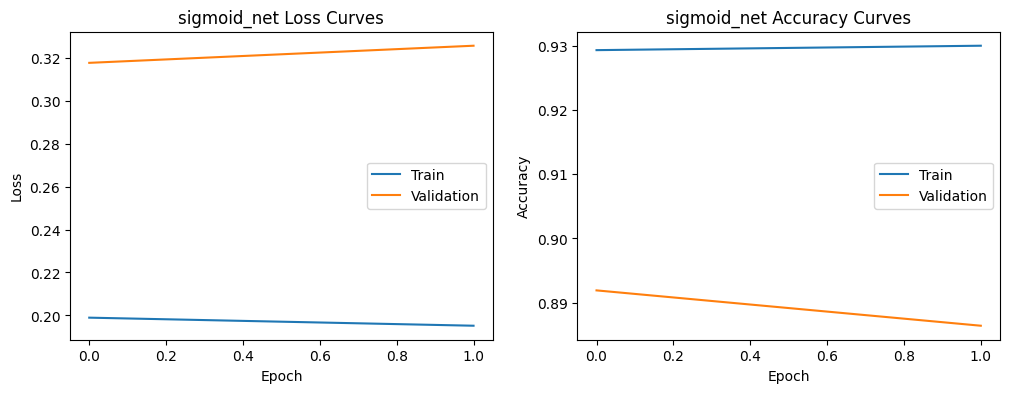

In [67]:
# 5 Implementation

# 5.1 Useage for model 1: sigmoid_net
num_epochs = 10
learning_rate = 0.01

train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(sigmoid_net, train_loader, val_loader, num_epochs, learning_rate)
plot_curves(train_losses, val_losses, train_accuracies, val_accuracies, 'sigmoid_net')

Epoch [1/10] Train Loss: 0.2394 Train Acc: 90.98% Val Loss: 0.3112 Val Acc: 88.99%
Epoch [2/10] Train Loss: 0.2330 Train Acc: 91.27% Val Loss: 0.3057 Val Acc: 89.01%
Epoch [3/10] Train Loss: 0.2276 Train Acc: 91.42% Val Loss: 0.3221 Val Acc: 88.67%
Validation loss increased. Stopping early.


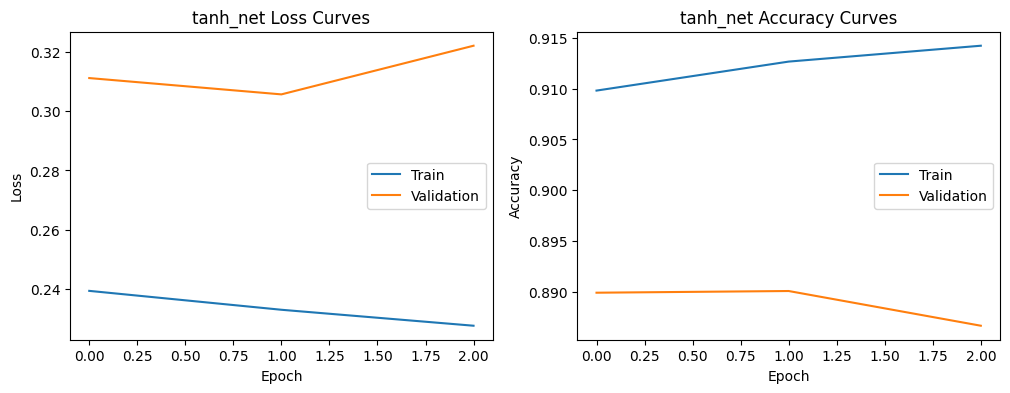

In [68]:
# 5.2 Useage for model 2: tanh_net
num_epochs = 10
learning_rate = 0.01

train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(tanh_net, train_loader, val_loader, num_epochs, learning_rate)
plot_curves(train_losses, val_losses, train_accuracies, val_accuracies, 'tanh_net')

Epoch [1/10] Train Loss: 0.2327 Train Acc: 91.39% Val Loss: 0.3154 Val Acc: 89.21%
Epoch [2/10] Train Loss: 0.2243 Train Acc: 91.75% Val Loss: 0.3119 Val Acc: 89.28%
Epoch [3/10] Train Loss: 0.2196 Train Acc: 91.81% Val Loss: 0.3032 Val Acc: 89.23%
Epoch [4/10] Train Loss: 0.2136 Train Acc: 92.02% Val Loss: 0.3137 Val Acc: 89.08%
Validation loss increased. Stopping early.


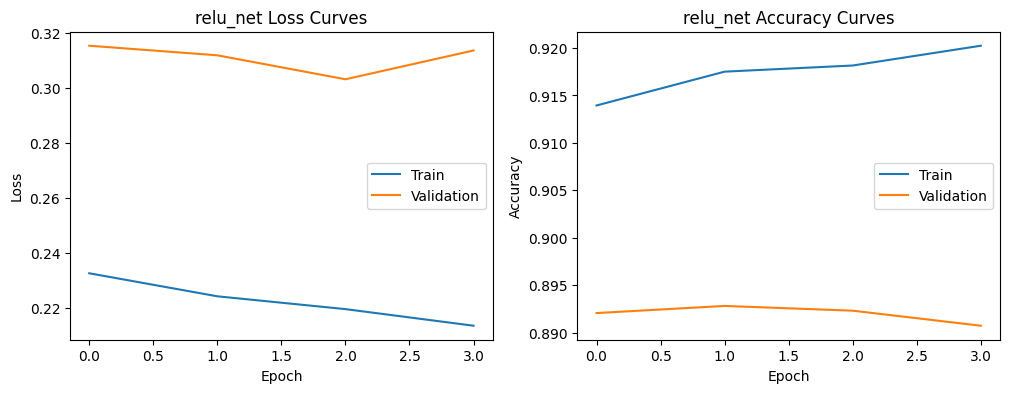

In [69]:
# 5.3 Useage for model 3: relu_net
num_epochs = 10
learning_rate = 0.01
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(relu_net, train_loader, val_loader, num_epochs, learning_rate)
plot_curves(train_losses, val_losses, train_accuracies, val_accuracies, 'relu_net')

Epoch [1/10] Train Loss: 0.2915 Train Acc: 89.08% Val Loss: 0.3193 Val Acc: 88.49%
Epoch [2/10] Train Loss: 0.2813 Train Acc: 89.60% Val Loss: 0.3273 Val Acc: 88.35%
Validation loss increased. Stopping early.


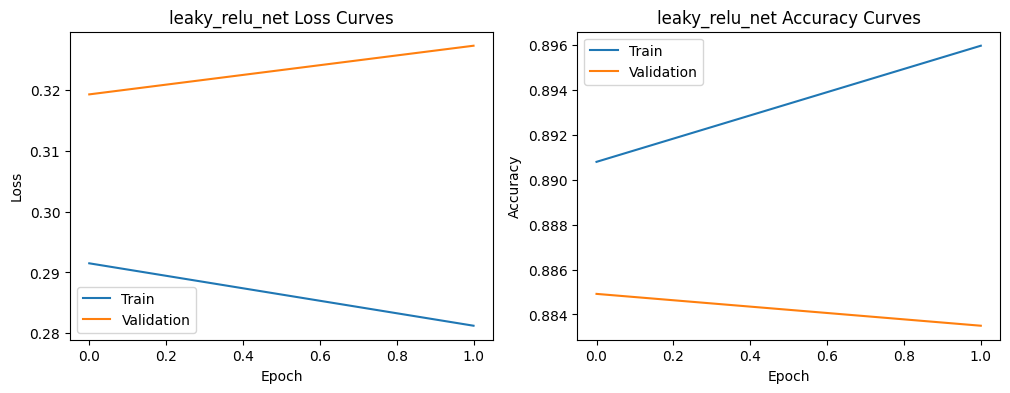

In [70]:
# 5.4 Useage for model 4: leaky_relu_net
num_epochs = 10
learning_rate = 0.01
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(leaky_relu_net, train_loader, val_loader, num_epochs, learning_rate)
plot_curves(train_losses, val_losses, train_accuracies, val_accuracies, 'leaky_relu_net')

Epoch [1/10] Train Loss: 0.3561 Train Acc: 86.90% Val Loss: 0.3584 Val Acc: 87.13%
Epoch [2/10] Train Loss: 0.3322 Train Acc: 87.71% Val Loss: 0.3459 Val Acc: 87.39%
Epoch [3/10] Train Loss: 0.3182 Train Acc: 88.23% Val Loss: 0.3653 Val Acc: 86.63%
Validation loss increased. Stopping early.


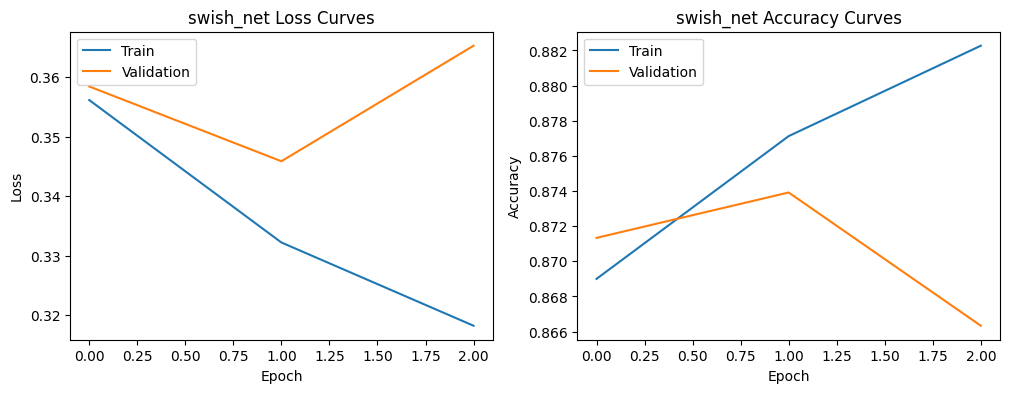

In [71]:
# 3.2.5 Useage for model 5: swish_net
num_epochs = 10
learning_rate = 0.01
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(swish_net, train_loader, val_loader, num_epochs, learning_rate)
plot_curves(train_losses, val_losses, train_accuracies, val_accuracies, 'swish_net')

Epoch [1/10] Train Loss: 0.8142 Train Acc: 69.39% Val Loss: 0.5116 Val Acc: 81.24%
Epoch [2/10] Train Loss: 0.4557 Train Acc: 83.15% Val Loss: 0.3871 Val Acc: 85.77%
Epoch [3/10] Train Loss: 0.3778 Train Acc: 86.01% Val Loss: 0.3549 Val Acc: 86.80%
Epoch [4/10] Train Loss: 0.3391 Train Acc: 87.60% Val Loss: 0.3324 Val Acc: 88.00%
Epoch [5/10] Train Loss: 0.3167 Train Acc: 88.32% Val Loss: 0.3102 Val Acc: 88.72%
Epoch [6/10] Train Loss: 0.2970 Train Acc: 88.89% Val Loss: 0.3031 Val Acc: 88.87%
Epoch [7/10] Train Loss: 0.2814 Train Acc: 89.55% Val Loss: 0.2935 Val Acc: 89.03%
Epoch [8/10] Train Loss: 0.2698 Train Acc: 90.01% Val Loss: 0.2995 Val Acc: 89.12%
Validation loss increased. Stopping early.


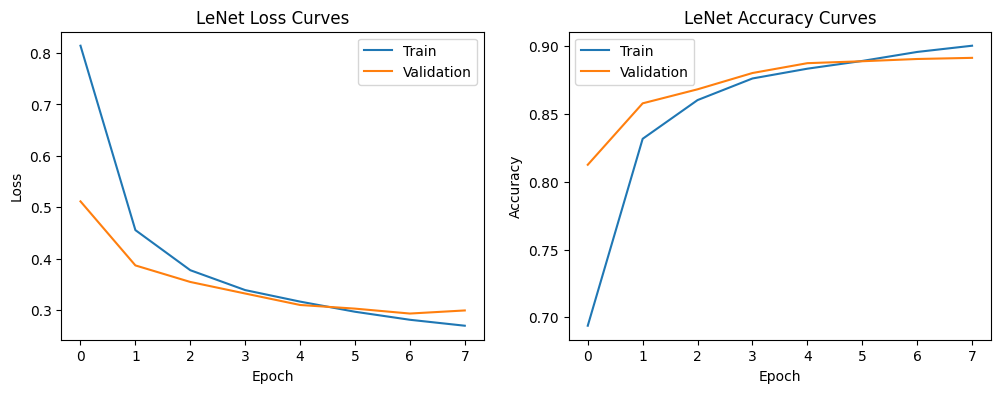

In [72]:
# 3.3 Usage for model 6: LeNet
lenet_model = LeNet(num_classes) # Instantiate
num_epochs = 10
learning_rate = 0.01
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(lenet_model, train_loader, val_loader, num_epochs, learning_rate)
plot_curves(train_losses, val_losses, train_accuracies, val_accuracies, 'LeNet')

In [64]:
# 3.4 Usage for model 7: ResNet
custom_resnet = CustomResNet(resnet)

num_epochs = 1
learning_rate = 0.01
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(custom_resnet, train_loader2, val_loader2, num_epochs, learning_rate)

KeyboardInterrupt: 